# 🏢 AI-Driven Company Intelligence Analysis
**SDS Datathon 2026 - Champions Group Dataset**

---

## 📋 Problem Statement
Develop a prototype system that derives actionable insights from company-level data by analyzing firmographic, operational, and organizational attributes.

### Objectives
1.  **Data Cleaning**: Robust handling of missing values and inconsistencies.
2.  **Segmentation**: Multi-dimensional clustering of companies.
3.  **Benchmarking**: Comparing performance against industry peers.
4.  **Lead Scoring**: Identifying high-value B2B targets.
5.  **Risk Detection**: Flagging anomalies and potential risks.

## 1. Environment Setup & Data Loading

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Libraries loaded.")

✅ Libraries loaded.


## 2. Data Loading & Initial Exploration

In [433]:
# Load Dataset
try:
    df = pd.read_csv('../data/champions_group_data.csv', on_bad_lines='skip')
    print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ Error: 'champions_group_data.csv' not found. Please ensure the file is in the correct directory.")

📊 Dataset Shape: 8,559 rows × 72 columns


## 3. Data Quality Assessment

In [434]:
def data_quality_report(df):
    """
    Generate comprehensive data quality report
    """
    report = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Null Count': df.isnull().sum().values,
        'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2).values,
        'Dtype': df.dtypes.values,
        'Unique Values': df.nunique().values,
        'Sample Value': df.iloc[0].values
    })
    return report.sort_values('Null Percentage', ascending=False)

quality_report = data_quality_report(df)
print("📊 Data Quality Report (Top 20 columns by missing values):")
quality_report.head(20)

📊 Data Quality Report (Top 20 columns by missing values):


Column  Non-Null Count  Null Count  Null Percentage  \
24                    Ticker               4        8555           99.950   
49  Registration Number Type               8        8551           99.910   
58      Manufacturing Status             261        8298           96.950   
2                    Website             625        7934           92.700   
60               ANZSIC Code            1426        7133           83.340   
61        ANZSIC Description            1428        7131           83.320   
54           Is Headquarters            1467        7092           82.860   
23    NACE Rev 2 Description            1512        7047           82.330   
63    ISIC Rev 4 Description            1514        7045           82.310   
55      Is Domestic Ultimate            1514        7045           82.310   
62           ISIC Rev 4 Code            1514        7045           82.310   
22           NACE Rev 2 Code            1514        7045           82.310   
9               Phone Number            1674        6885           80.440   
26                 Lattitude            1912        6647           77.660   
27                 Longitude            1912        6647           77.660   
57          Franchise Status            2521        6038           70.550   
50       Company Description            3085        5474           63.960   
21         NAICS Description            3172        5387           62.940   
20                NAICS Code            3172        5387           62.940   
18          8-Digit SIC Code            3250        5309           62.030   

      Dtype  Unique Values                                       Sample Value  
24  float64              4                                                NaN  
49   object              1                                                NaN  
58   object              1                                                NaN  
2    object            498                                                NaN  
60  float64            136                                           3322.000  
61   object            137                      Metal and Mineral Wholesaling  
54  float64              2                                              0.000  
23   object            177                 Wholesale of metals and metal ores  
63   object            147                 Wholesale of metals and metal ores  
55  float64              2                                              0.000  
62  float64            150                                           4662.000  
22  float64            177                                           4672.000  
9   float64           1670                                                NaN  
26   object            342                                                NaN  
27  float64            326                                                NaN  
57   object              4                                              FALSE  
50   object           3056  Zyf Lopsking Material Technology Co., Ltd. No....  
21   object            344  Metal Service Centers and Other Metal Merchant...  
20  float64            345                                         423510.000  
18  float64            445                                       50510000.000

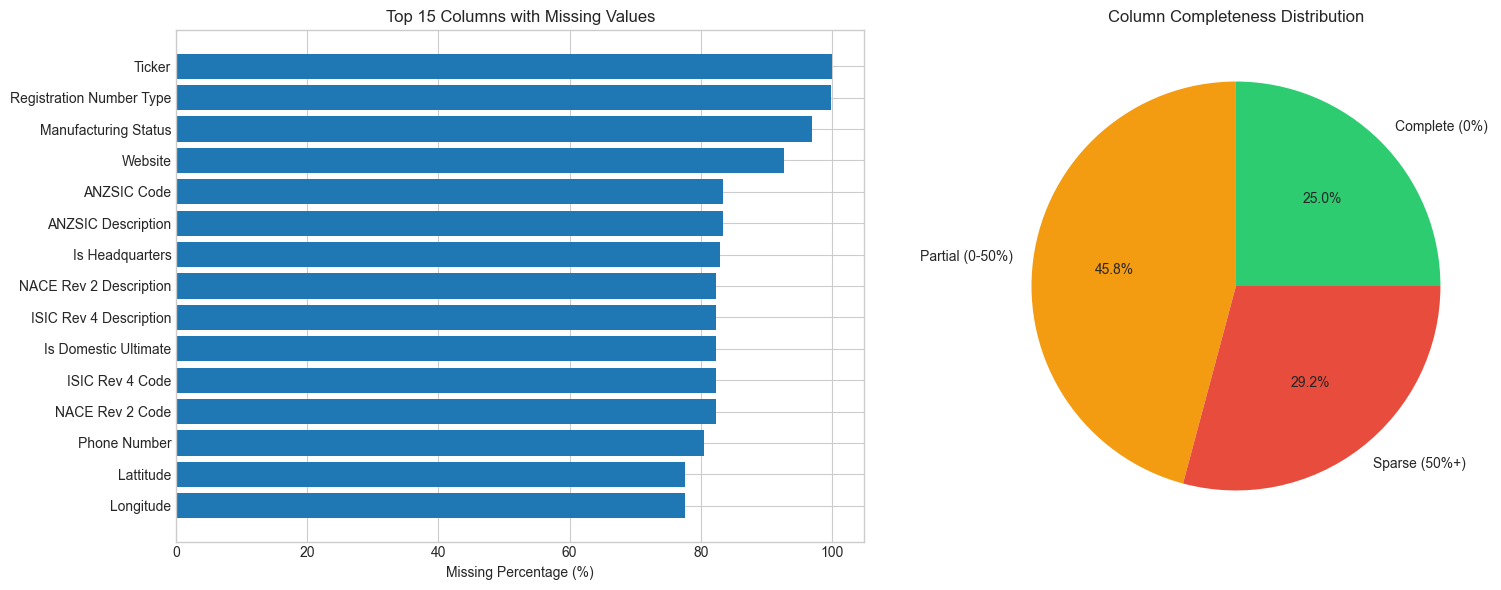

In [435]:
# Visualize missing data pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Missing percentage bar chart (top 15)
top_missing = quality_report.head(15)
axes[0].barh(top_missing['Column'].astype(str), top_missing['Null Percentage'])
axes[0].set_xlabel('Missing Percentage (%)')
axes[0].set_title('Top 15 Columns with Missing Values')
axes[0].invert_yaxis()

# Data completeness pie chart
complete_cols = (quality_report['Null Percentage'] == 0).sum()
partial_cols = ((quality_report['Null Percentage'] > 0) & (quality_report['Null Percentage'] < 50)).sum()
sparse_cols = (quality_report['Null Percentage'] >= 50).sum()

axes[1].pie([complete_cols, partial_cols, sparse_cols],
            labels=['Complete (0%)', 'Partial (0-50%)', 'Sparse (50%+)'],
            autopct='%1.1f%%', colors=['#2ecc71', '#f39c12', '#e74c3c'])
axes[1].set_title('Column Completeness Distribution')

plt.tight_layout()
plt.show()

## 4. Exploratory Data Analysis (EDA)

### 4.1 Geographic Distribution

In [436]:
# Country distribution
df['Country'] = df['Country'].str.strip().str.upper()
country_dist = df['Country'].value_counts().head(20)

fig = px.bar(x=country_dist.values, y=country_dist.index, orientation='h',
             title='Top 20 Countries by Company Count',
             labels={'x': 'Number of Companies', 'y': 'Country'})
fig.update_layout(height=600)
fig.show()

In [437]:
# Region distribution
if 'Region' in df.columns:
    df['Region'] = df['Region'].str.strip()
    region_dist = df['Region'].value_counts()

    fig = px.pie(values=region_dist.values, names=region_dist.index,
                 title='Company Distribution by Region')
    fig.show()

### 4.2 Company Size & Revenue Analysis

In [438]:
# Convert numeric columns
def clean_numeric(col):
    """Clean and convert to numeric"""
    if df[col].dtype == 'object':
        # Remove common non-numeric characters
        cleaned = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True)
        return pd.to_numeric(cleaned, errors='coerce')
    return pd.to_numeric(df[col], errors='coerce')

# Key numeric columns
df['Employees_Total_Clean'] = clean_numeric('Employees Total')
df['Revenue_USD_Clean'] = clean_numeric('Revenue (USD)')
df['Employees_Single_Site_Clean'] = clean_numeric('Employees Single Site')

print("📊 Employee & Revenue Statistics:")
print(df[['Employees_Total_Clean', 'Revenue_USD_Clean', 'Employees_Single_Site_Clean']].describe())

📊 Employee & Revenue Statistics:
       Employees_Total_Clean  Revenue_USD_Clean  Employees_Single_Site_Clean
count               8559.000           8559.000                     8557.000
mean                  22.658        3960698.980                       22.666
std                   99.689       45102121.815                       99.700
min                    0.000              0.000                        0.000
25%                    0.000              0.000                        0.000
50%                    4.000         443445.000                        4.000
75%                   21.000        2099812.000                       21.000
max                 3290.000     2961727200.000                     3290.000


In [439]:
# Revenue distribution (log scale)
revenue_data = df['Revenue_USD_Clean'].dropna()
revenue_data = revenue_data[revenue_data > 0]

fig = px.histogram(x=np.log10(revenue_data), nbins=50,
                   title='Revenue Distribution (Log10 Scale)',
                   labels={'x': 'Log10(Revenue USD)'})
fig.show()

In [440]:
# Create company size segments
def company_size_segment(employees):
    if pd.isna(employees) or employees == 0:
        return 'Unknown'
    elif employees < 10:
        return 'Micro (1-9)'
    elif employees < 50:
        return 'Small (10-49)'
    elif employees < 250:
        return 'Medium (50-249)'
    elif employees < 1000:
        return 'Large (250-999)'
    else:
        return 'Enterprise (1000+)'

df['Company_Size_Segment'] = df['Employees_Total_Clean'].apply(company_size_segment)

# Visualize
size_order = ['Micro (1-9)', 'Small (10-49)', 'Medium (50-249)', 'Large (250-999)', 'Enterprise (1000+)', 'Unknown']
size_dist = df['Company_Size_Segment'].value_counts().reindex(size_order, fill_value=0)

fig = px.bar(x=size_dist.index, y=size_dist.values,
             title='Company Size Distribution',
             labels={'x': 'Size Segment', 'y': 'Number of Companies'},
             color=size_dist.index)
fig.show()

### 4.3 Industry Analysis

In [441]:
# SIC Code Analysis
df['SIC Description'] = df['SIC Description'].str.strip()
industry_dist = df['SIC Description'].value_counts().head(20)

fig = px.bar(x=industry_dist.values, y=industry_dist.index, orientation='h',
             title='Top 20 Industries (SIC Description)',
             labels={'x': 'Number of Companies', 'y': 'Industry'})
fig.update_layout(height=700)
fig.show()

In [442]:
# NAICS Industry Analysis
if 'NAICS Description' in df.columns:
    df['NAICS Description'] = df['NAICS Description'].str.strip()
    naics_dist = df['NAICS Description'].value_counts().head(15)

    fig = px.treemap(names=naics_dist.index, parents=[''] * len(naics_dist), values=naics_dist.values,
                     title='Industry Distribution (NAICS) - Treemap')
    fig.show()

### 4.4 Entity & Ownership Analysis

In [443]:
# Entity Type Distribution
if 'Entity Type' in df.columns:
    df['Entity Type'] = df['Entity Type'].str.strip()
    entity_dist = df['Entity Type'].value_counts()

    fig = px.pie(values=entity_dist.values, names=entity_dist.index,
                 title='Entity Type Distribution (HQ, Subsidiary, Branch, Single Location)',
                 hole=0.4)
    fig.show()

In [444]:
# Ownership Type
if 'Ownership Type' in df.columns:
    df['Ownership Type'] = df['Ownership Type'].str.strip()
    ownership_dist = df['Ownership Type'].value_counts()

    fig = px.pie(values=ownership_dist.values, names=ownership_dist.index,
                 title='Ownership Type Distribution (Private vs Public)')
    fig.show()

### 4.5 IT Infrastructure Analysis

In [445]:
# IT related columns analysis
it_columns = ['IT Budget', 'IT Spend', 'No. of PC', 'No. of Desktops', 'No. of Laptops',
              'No. of Routers', 'No. of Servers', 'No. of Storage Devices']

it_exists = [col for col in it_columns if col in df.columns]
print(f"IT-related columns in dataset: {it_exists}")

# Check IT data completeness
for col in it_exists:
    non_null = df[col].notnull().sum()
    pct = (non_null / len(df) * 100)
    print(f"{col}: {non_null:,} non-null values ({pct:.1f}%)")

IT-related columns in dataset: ['IT Budget', 'No. of PC', 'No. of Desktops', 'No. of Laptops', 'No. of Routers', 'No. of Servers', 'No. of Storage Devices']
IT Budget: 8,559 non-null values (100.0%)
No. of PC: 8,278 non-null values (96.7%)
No. of Desktops: 8,218 non-null values (96.0%)
No. of Laptops: 7,920 non-null values (92.5%)
No. of Routers: 5,260 non-null values (61.5%)
No. of Servers: 5,210 non-null values (60.9%)
No. of Storage Devices: 5,126 non-null values (59.9%)


## 5. Enhanced Data Cleaning
Handling missing values, standardizing formats, and creating clean numeric columns.

In [446]:
print("🔧 Cleaning numeric columns...")

def clean_numeric_series(series):
    return pd.to_numeric(series.astype(str).str.replace(',', '').str.strip(), errors='coerce')

# Clean key columns (keep NaNs as NaNs initially)
revenue_raw = clean_numeric_series(df['Revenue (USD)'])
employees_raw = clean_numeric_series(df['Employees Total'])

# Create explicit missing value flags
df['Is_Revenue_Missing'] = revenue_raw.isna() | (revenue_raw == 0)
df['Is_Employees_Missing'] = employees_raw.isna() | (employees_raw == 0)


# Prepare for KNN Imputation
print("   Performing KNN Imputation for missing values...")
impute_df = pd.DataFrame({
    'Revenue': revenue_raw.replace(0, np.nan),
    'Employees': employees_raw.replace(0, np.nan)
})

# Log transform for better KNN performance on skewed data
impute_df['Revenue'] = np.log1p(impute_df['Revenue'])
impute_df['Employees'] = np.log1p(impute_df['Employees'])

# Add Entity Type as ordinal feature to help imputation
entity_map_impute = {'Headquarters': 4, 'Single Location': 3, 'Subsidiary': 2, 'Branch': 1}
impute_df['Entity_Ord'] = df['Entity Type'].map(entity_map_impute).fillna(1)

# Scale before KNN
scaler_impute = StandardScaler()
impute_scaled = scaler_impute.fit_transform(impute_df)

# Impute (using 5 neighbors)
knn_imputer = KNNImputer(n_neighbors=5)
impute_filled_scaled = knn_imputer.fit_transform(impute_scaled)

# Inverse transform to get original scale (still log-transformed)
impute_filled_log = scaler_impute.inverse_transform(impute_filled_scaled)

# Inverse transform log (expm1) to get actual values
df['Revenue_USD_Clean'] = np.expm1(impute_filled_log[:, 0])
df['Employees_Total_Clean'] = np.expm1(impute_filled_log[:, 1])

# Fill other numeric columns
df['Employees_Site_Clean'] = clean_numeric_series(df['Employees Single Site']).fillna(0)
df['Corporate_Family_Size'] = clean_numeric_series(df['Corporate Family Members']).fillna(0)

print(f"   Revenue missing/zero: {df['Is_Revenue_Missing'].sum():,} ({df['Is_Revenue_Missing'].mean()*100:.1f}%)")
print(f"   Employees missing/zero: {df['Is_Employees_Missing'].sum():,} ({df['Is_Employees_Missing'].mean()*100:.1f}%)")


🔧 Cleaning numeric columns...
   Performing KNN Imputation for missing values...
   Revenue missing/zero: 3,316 (38.7%)
   Employees missing/zero: 3,132 (36.6%)


## 6. Feature Engineering
Creating derived metrics like Entity Score, Revenue Per Employee, and Data Completeness.

In [447]:
## 6. Feature Engineering
# -------------------------------------------------------
print("🛠 Engineering features (Adding Age, Market Value, IT, Domestic Power)...")

# 1. Auxiliary Functions
def clean_boolean(val):
    """Cleaning Yes/No/1/0"""
    s = str(val).lower()
    if s in ['yes', 'true', '1']: return 1
    return 0

# 2. Hierarchy Power (Domestic Ultimate Only) 
# -------------------------------------------------------
if 'Is Domestic Ultimate' in df.columns:
    df['Is_Domestic_Ultimate_Clean'] = df['Is Domestic Ultimate'].apply(clean_boolean)
    print(f"   Processed Domestic Ultimates: {(df['Is_Domestic_Ultimate_Clean']==1).sum():,} companies.")
else:
    df['Is_Domestic_Ultimate_Clean'] = 0
    print("   ⚠️ Column 'Is Domestic Ultimate' not found. Set to 0.")

# 3. Company Age (Stability)
# -------------------------------------------------------
current_year = 2026
df['Year_Found_Clean'] = pd.to_numeric(df['Year Found'], errors='coerce')
df['Company_Age'] = current_year - df['Year_Found_Clean']
age_median = df['Company_Age'].median()
df['Company_Age'] = df['Company_Age'].clip(0, 200).fillna(age_median)

# 4. Market Value (Financial Power)
# -------------------------------------------------------
df['Market_Value_Clean'] = pd.to_numeric(
    df['Market Value (USD)'].astype(str).str.replace(r'[^\d.]', '', regex=True), 
    errors='coerce'
).fillna(0)

# 5. IT Spend per Employee (Tech Maturity)
# -------------------------------------------------------
df['IT_Spend_Clean'] = pd.to_numeric(
    df['IT spend'].astype(str).str.replace(r'[^\d.]', '', regex=True), 
    errors='coerce'
).fillna(0)
df['IT_Spend_Per_Emp'] = df['IT_Spend_Clean'] / df['Employees_Total_Clean'].replace(0, np.nan)
df['IT_Spend_Per_Emp'] = df['IT_Spend_Per_Emp'].fillna(0)

# 6. Standard Features
# -------------------------------------------------------
# Map: Parent=3, Subsidiary=2, Branch=1
entity_map = {'Parent': 3, 'Subsidiary': 2, 'Branch': 1}
df['Entity_Score'] = df['Entity Type'].map(entity_map).fillna(1)

df['Has_Parent'] = df['Parent Company'].notna().astype(int)
df['SIC_2Digit'] = df['SIC Code'].astype(str).str[:2]

df['Revenue_Per_Employee'] = df['Revenue_USD_Clean'] / df['Employees_Total_Clean'].replace(0, np.nan)
df['Revenue_Per_Employee'] = df['Revenue_Per_Employee'].fillna(df['Revenue_Per_Employee'].median())

# Data Completeness
df['Data_Completeness'] = (
    (~df['Is_Revenue_Missing']).astype(int) +
    (~df['Is_Employees_Missing']).astype(int) +
    df['SIC Code'].notna().astype(int) +
    df['Entity Type'].notna().astype(int) +
    df['Region'].notna().astype(int) +
    df['Country'].notna().astype(int) +
    df['Year Found'].notna().astype(int)
) / 7

# Log Transforms
df['Log_Revenue'] = np.log1p(df['Revenue_USD_Clean'])
df['Log_Employees'] = np.log1p(df['Employees_Total_Clean'])
df['Log_Market_Value'] = np.log1p(df['Market_Value_Clean'])
df['Log_IT_Spend'] = np.log1p(df['IT_Spend_Clean'])

print("✅ Feature Engineering Complete (Safe Version).")

🛠 Engineering features (Adding Age, Market Value, IT, Domestic Power)...
   Processed Domestic Ultimates: 0 companies.
✅ Feature Engineering Complete (Safe Version).


## 7. Industry Benchmarking
Comparing company performance against 2-digit SIC industry peers.

In [448]:
print("📊 Calculating industry benchmarks...")

# Aggregation
industry_stats = df.groupby('SIC_2Digit').agg(
    Ind_Revenue_Median=('Revenue_USD_Clean', 'median'),
    Ind_Revenue_Mean=('Revenue_USD_Clean', 'mean'),
    Ind_Employees_Median=('Employees_Total_Clean', 'median'),
    Ind_Employees_Mean=('Employees_Total_Clean', 'mean'),
    Ind_Count=('Revenue_USD_Clean', 'count')
).reset_index()

# Clean Merge: Drop existing columns to prevent duplicates
cols_to_drop = [c for c in industry_stats.columns if c in df.columns and c != 'SIC_2Digit']
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)

# Merge
df = df.merge(industry_stats, on='SIC_2Digit', how='left')

# Calculate Deviations (%)
df['Revenue_vs_Industry'] = np.where(
    df['Ind_Revenue_Median'] > 0,
    (df['Revenue_USD_Clean'] / df['Ind_Revenue_Median'] - 1) * 100,
    0
).clip(-100, 500)

df['Employees_vs_Industry'] = np.where(
    df['Ind_Employees_Median'] > 0,
    (df['Employees_Total_Clean'] / df['Ind_Employees_Median'] - 1) * 100,
    0
).clip(-100, 500)

print(f"   Benchmarked against {len(industry_stats)} industry sectors")

📊 Calculating industry benchmarks...
   Benchmarked against 77 industry sectors


## 8. Multi-Dimensional Clustering
Segmenting companies using K-Means on Size, Structure, and Efficiency.


SECTION 8: CLUSTERING & STRUCTURAL VALIDATION

[8.1] Determining Optimal Clusters...
   Calculating metrics for k=2..10...


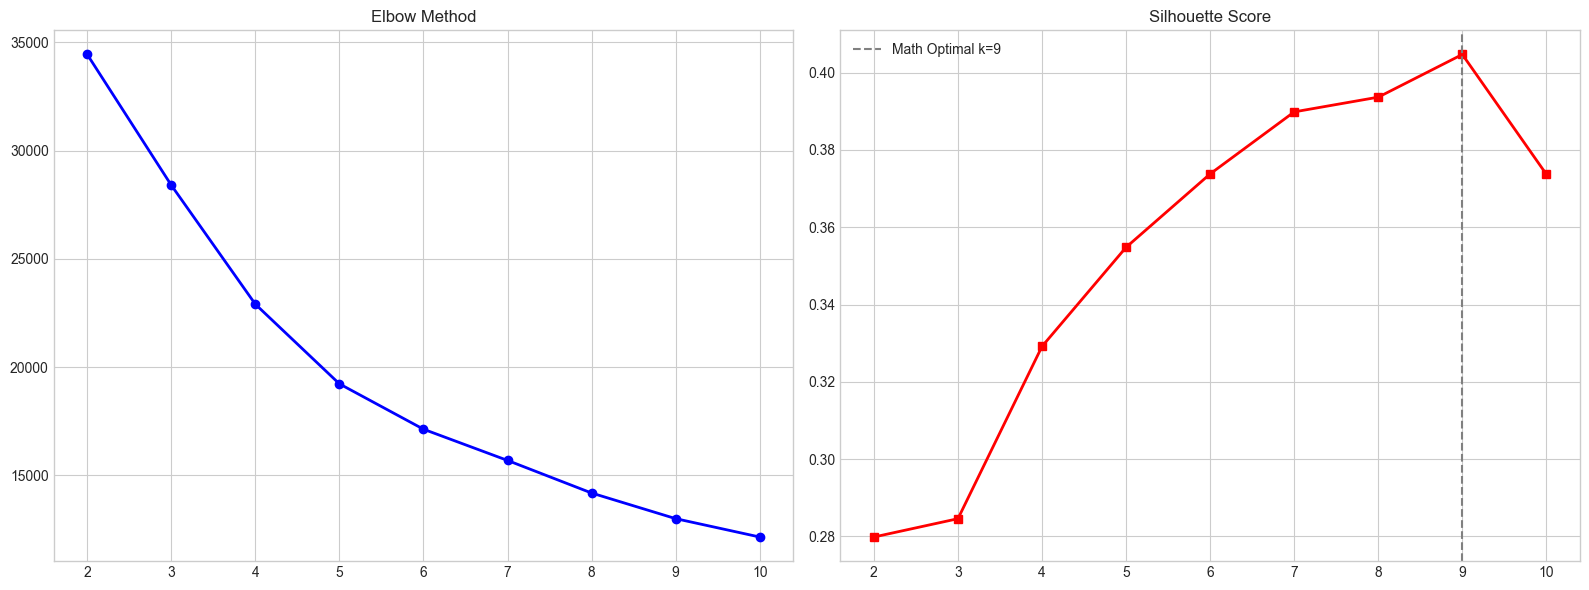


[8.2] Applying Final Clustering Model...
   Math suggests k=9, selecting k=5 for business interpretability.
   ✅ Clusters Assigned & Named.

[8.3] Technical Validation...


   Running UMAP...



✅ Section 8 Complete.


In [449]:
# ==========================================
# 8. Multi-Dimensional Clustering & Validation
# ==========================================
print("\n" + "="*50)
print("SECTION 8: CLUSTERING & STRUCTURAL VALIDATION")
print("="*50)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.utils import resample

# -------------------------------------------------------
# 8.1 Determining Optimal Clusters
# -------------------------------------------------------
print("\n[8.1] Determining Optimal Clusters...")

# 1. Prepare Features (Removed risky Global Ultimate)
cluster_features = [
    'Log_Revenue', 
    'Log_Employees', 
    'Entity_Score', 
    'Has_Parent', 
    'Revenue_Per_Employee', 
    'Company_Age',
    'Is_Domestic_Ultimate_Clean' 
]
X_cluster = df[cluster_features].copy()
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan).fillna(X_cluster.median())

# 2. Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. Calculate Metrics
k_range = range(2, 11)
inertias = []
silhouette_scores = []
sample_size = 10000
use_sample = len(X_scaled) > sample_size

print(f"   Calculating metrics for k=2..10...")

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    
    if use_sample:
        X_sample, label_sample = resample(X_scaled, kmeans_temp.labels_, n_samples=sample_size, random_state=42)
        score = silhouette_score(X_sample, label_sample)
    else:
        score = silhouette_score(X_scaled, kmeans_temp.labels_)
    silhouette_scores.append(score)

# 4. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(k_range, inertias, 'bo-', linewidth=2)
ax1.set_title('Elbow Method')
ax2.plot(k_range, silhouette_scores, 'rs-', linewidth=2)
ax2.set_title('Silhouette Score')
best_k_math = k_range[np.argmax(silhouette_scores)]
ax2.axvline(x=best_k_math, color='gray', linestyle='--', label=f'Math Optimal k={best_k_math}')
ax2.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 8.2 Applying Final Clustering (Business Override)
# -------------------------------------------------------
print("\n[8.2] Applying Final Clustering Model...")

# Force k=5
best_k = 5 
print(f"   Math suggests k={best_k_math}, selecting k={best_k} for business interpretability.")

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Naming Logic
def get_cluster_context(df_data):
    profiles = df_data.groupby('Cluster').agg({
        'Revenue_USD_Clean': 'median',
        'Entity_Score': lambda x: x.mode().iloc[0] if not x.mode().empty else x.mean()
    }).reset_index()
    profiles['Rank'] = profiles['Revenue_USD_Clean'].rank(ascending=False, method='min').astype(int)

    def generate_name(row):
        tier = f"Tier {row['Rank']}"
        score = row['Entity_Score']
        # Parent(3), Sub(2), Branch(1)
        if score >= 2.8: structure = "Parent HQ"
        elif score >= 1.8: structure = "Subsidiary"
        else: structure = "Branch"
        return f"{tier} {structure}"

    profiles['Cluster_Name'] = profiles.apply(generate_name, axis=1)
    return profiles.set_index('Cluster')['Cluster_Name'].to_dict()

cluster_names_map = get_cluster_context(df)
df['Cluster_Name'] = df['Cluster'].map(cluster_names_map)

print(f"   ✅ Clusters Assigned & Named.")

# -------------------------------------------------------
# 8.3 Structural Validation (PCA & UMAP)
# -------------------------------------------------------
print("\n[8.3] Technical Validation...")

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
var_explained = pca.explained_variance_ratio_.sum() * 100

fig_pca = px.scatter(
    x=pca_result[:, 0], y=pca_result[:, 1], color=df['Cluster_Name'],
    title=f'PCA Validation (Captures {var_explained:.1f}% Variance)',
    labels={'x':'PC1', 'y':'PC2'}, opacity=0.6,
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig_pca.show()

# UMAP
try:
    import umap.umap_ as umap
    print("   Running UMAP...")
    
    reducer = umap.UMAP(
        n_neighbors=50,   
        min_dist=0.0,    
        n_components=2, 
        random_state=42
    )
    umap_result = reducer.fit_transform(X_scaled)
    
    fig_umap = px.scatter(
        x=umap_result[:, 0], y=umap_result[:, 1], color=df['Cluster_Name'],
        title='UMAP Projection: Cluster Topology',
        labels={'x':'Dimension 1', 'y':'Dimension 2'}, 
        opacity=0.6,
        color_discrete_sequence=px.colors.qualitative.Bold
    )
    fig_umap.update_layout(height=600, plot_bgcolor='white')
    fig_umap.update_xaxes(showgrid=False, zeroline=False, showticklabels=False)
    fig_umap.update_yaxes(showgrid=False, zeroline=False, showticklabels=False)
    fig_umap.show()
except ImportError:
    print("   (UMAP skipped)")

print("\n✅ Section 8 Complete.")

## 9. Anomaly Detection & Risk Profiling
Prioritizing targets and flagging high-risk entities.

In [450]:
## 9. Anomaly Detection & Risk Profiling
# -------------------------------------------------------
print("\n" + "="*50)
print("SECTION 9: ANOMALY DETECTION & RISK PROFILING")
print("="*50)

from sklearn.ensemble import IsolationForest

# -------------------------------------------------------
# 9.1 Statistical Anomalies (Isolation Forest)
# -------------------------------------------------------
print("\n[9.1] Identifying Statistical Anomalies...")

# Use the same Scaled Features as clustering
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Score'] = iso_forest.fit_predict(X_scaled)

# Label conversion: -1 = Anomaly, 1 = Normal
df['Anomaly_Label'] = df['Anomaly_Score'].map({1: 'Normal', -1: 'Anomaly'})
df['Risk_Flag_Anomaly'] = (df['Anomaly_Label'] == 'Anomaly').astype(int)

# -------------------------------------------------------
# 9.2 Business Rule Risks (The Critical Fix)
# -------------------------------------------------------
print("[9.2] Applying Business Risk Rules...")

# 1. Shell Company Risk 
# Logic: Revenue is very high (>100,000), but the original data shows the number of employees as empty or 0 (Is_Employees_Missing=True).
df['Risk_Shell'] = (df['Revenue_USD_Clean'] > 100_000) & (df['Is_Employees_Missing'] == 1)

# 2. Data Quality Risk
# Logic: Many key fields are missing (Data_Completeness < 50%)
df['Risk_DataQuality'] = df['Data_Completeness'] < 0.5

# 3. Orphan Subsidiary Risk
# Logic: The type is subsidiary, but there is no parent company link.
df['Risk_OrphanSub'] = (df['Entity Type'] == 'Subsidiary') & (df['Has_Parent'] == 0)

# 4. Combined Risk Score (Total Flags)
df['Risk_Flags'] = (
    df['Risk_Shell'].astype(int) + 
    df['Risk_DataQuality'].astype(int) + 
    df['Risk_OrphanSub'].astype(int) + 
    df['Risk_Flag_Anomaly']
)

# Print Summary
print(f"   ⚠️ Risk Analysis Summary:")
print(f"      Shell Companies (High Rev, No Emp): {df['Risk_Shell'].sum():,}")
print(f"      Orphan Subsidiaries: {df['Risk_OrphanSub'].sum():,}")
print(f"      Data Quality Risks: {df['Risk_DataQuality'].sum():,}")
print(f"      Statistical Anomalies: {df['Risk_Flag_Anomaly'].sum():,}")

# -------------------------------------------------------
# 9.3 Visualization: Where are the Risks?
# -------------------------------------------------------
# Draw a diagram and mark the outliers in red.
fig = px.scatter(
    df, x='Log_Revenue', y='Log_Employees',
    color='Anomaly_Label',
    title='Anomaly Detection: Isolating Statistical Outliers',
    color_discrete_map={'Normal': 'lightgray', 'Anomaly': 'red'}, # Gray background, red highlight
    hover_data=['Revenue (USD)', 'Employees Total', 'Cluster_Name', 'Risk_Shell'],
    opacity=0.6
)
fig.update_layout(height=600)
fig.show()

# -------------------------------------------------------
# 9.4 Profiling High-Risk Examples
# -------------------------------------------------------
print("\n[9.4] Profiling High-Risk Examples...")

# Show Shell Suspects
shells = df[df['Risk_Shell'] == True].nlargest(3, 'Revenue_USD_Clean')
if len(shells) > 0:
    print(f"   🚩 Top Potential Shell Companies (High Rev, Missing Emp):")
    for idx, row in shells.iterrows():
        print(f"      - {row['Company Sites']}: Rev=${row['Revenue_USD_Clean']:,.0f} (Raw Emp Missing: {row['Is_Employees_Missing']})")
else:
    print("   ✅ No Shell Companies detected (Clean dataset).")

print("\n✅ Section 9 Complete.")


SECTION 9: ANOMALY DETECTION & RISK PROFILING

[9.1] Identifying Statistical Anomalies...
[9.2] Applying Business Risk Rules...
   ⚠️ Risk Analysis Summary:
      Shell Companies (High Rev, No Emp): 3,063
      Orphan Subsidiaries: 0
      Data Quality Risks: 0
      Statistical Anomalies: 428



[9.4] Profiling High-Risk Examples...
   🚩 Top Potential Shell Companies (High Rev, Missing Emp):
      - Zhejiang Mingye Construction Co., Ltd.                                                    : Rev=$2,961,727,200 (Raw Emp Missing: True)
      - Yonfer Agricultural Technology Co., Ltd.                                                  : Rev=$2,213,321,609 (Raw Emp Missing: True)
      - Sinosteel Shipping& Forwarding Co., Ltd.                                                  : Rev=$518,268,069 (Raw Emp Missing: True)

✅ Section 9 Complete.


## 10. B2B Lead Scoring & Risk Detection
Prioritizing targets and flagging high-risk entities.

In [451]:
## 10. B2B Lead Scoring & Risk Detection (Revised)
# -------------------------------------------------------
print("💰 Calculating Lead Scores (Domestic Priority)...")

def calculate_lead_score_enhanced(row):
    score = 0
    
    # 1. Revenue Scale (Max 35 pts)
    rev = row['Revenue_USD_Clean']
    if rev >= 1e8: score += 35      # >100M
    elif rev >= 1e7: score += 25    # >10M
    elif rev >= 1e6: score += 15    # >1M
    elif rev >= 1e5: score += 5
    
    # 2. Hierarchy & Power (Max 20 pts)
    if row['Is_Domestic_Ultimate_Clean'] == 1:
        score += 15
    else:
        score += row['Entity_Score'] * 3 
    
    # 3. Efficiency & Tech (Max 20 pts)
    rpe = row['Revenue_Per_Employee']
    it_spend = row['IT_Spend_Per_Emp']
    
    if rpe >= 5e5: score += 10
    elif rpe >= 1e5: score += 5
    
    if it_spend > 1000: score += 10 
    elif it_spend > 0: score += 5
    
    # 4. Market Validation (Max 15 pts)
    if row['Market_Value_Clean'] > 0:
        score += 15
    
    # 5. Stability / Age (Max 10 pts)
    age = row['Company_Age']
    if 3 <= age <= 10: score += 10  
    elif age > 10: score += 5       
    
    # Penalty
    if row['Data_Completeness'] < 0.5:
        score *= 0.8 
        
    return min(100, max(0, score))

df['Lead_Score'] = df.apply(calculate_lead_score_enhanced, axis=1)
df['Lead_Tier'] = pd.cut(df['Lead_Score'], bins=[0, 30, 50, 75, 100], labels=['Cold', 'Warm', 'Hot', 'Priority'])

# Risk Detection
df['Risk_Shell'] = (df['Revenue_USD_Clean'] > 1e5) & (df['Employees_Total_Clean'] == 0)
df['Risk_DataQuality'] = df['Data_Completeness'] < 0.5
df['Risk_OrphanSub'] = (df['Entity Type'] == 'Subsidiary') & (df['Has_Parent'] == 0)

# Combined Risk Score
if 'Risk_Flag_Anomaly' not in df.columns:
    df['Risk_Flag_Anomaly'] = 0 

df['Risk_Flags'] = (
    df['Risk_Shell'].astype(int) +
    df['Risk_DataQuality'].astype(int) +
    df['Risk_OrphanSub'].astype(int) +
    df['Risk_Flag_Anomaly'] 
)

print("   Lead Score Distribution:")
print(df['Lead_Tier'].value_counts())

💰 Calculating Lead Scores (Domestic Priority)...
   Lead Score Distribution:
Lead_Tier
Warm        3751
Hot         3140
Cold        1540
Priority     128
Name: count, dtype: int64


## 11. Visualization of Insights

🎨 Generating Comprehensive Visualizations...
   Generating 3D Macro View...


   Calculating Feature Importance & Industry Composition...


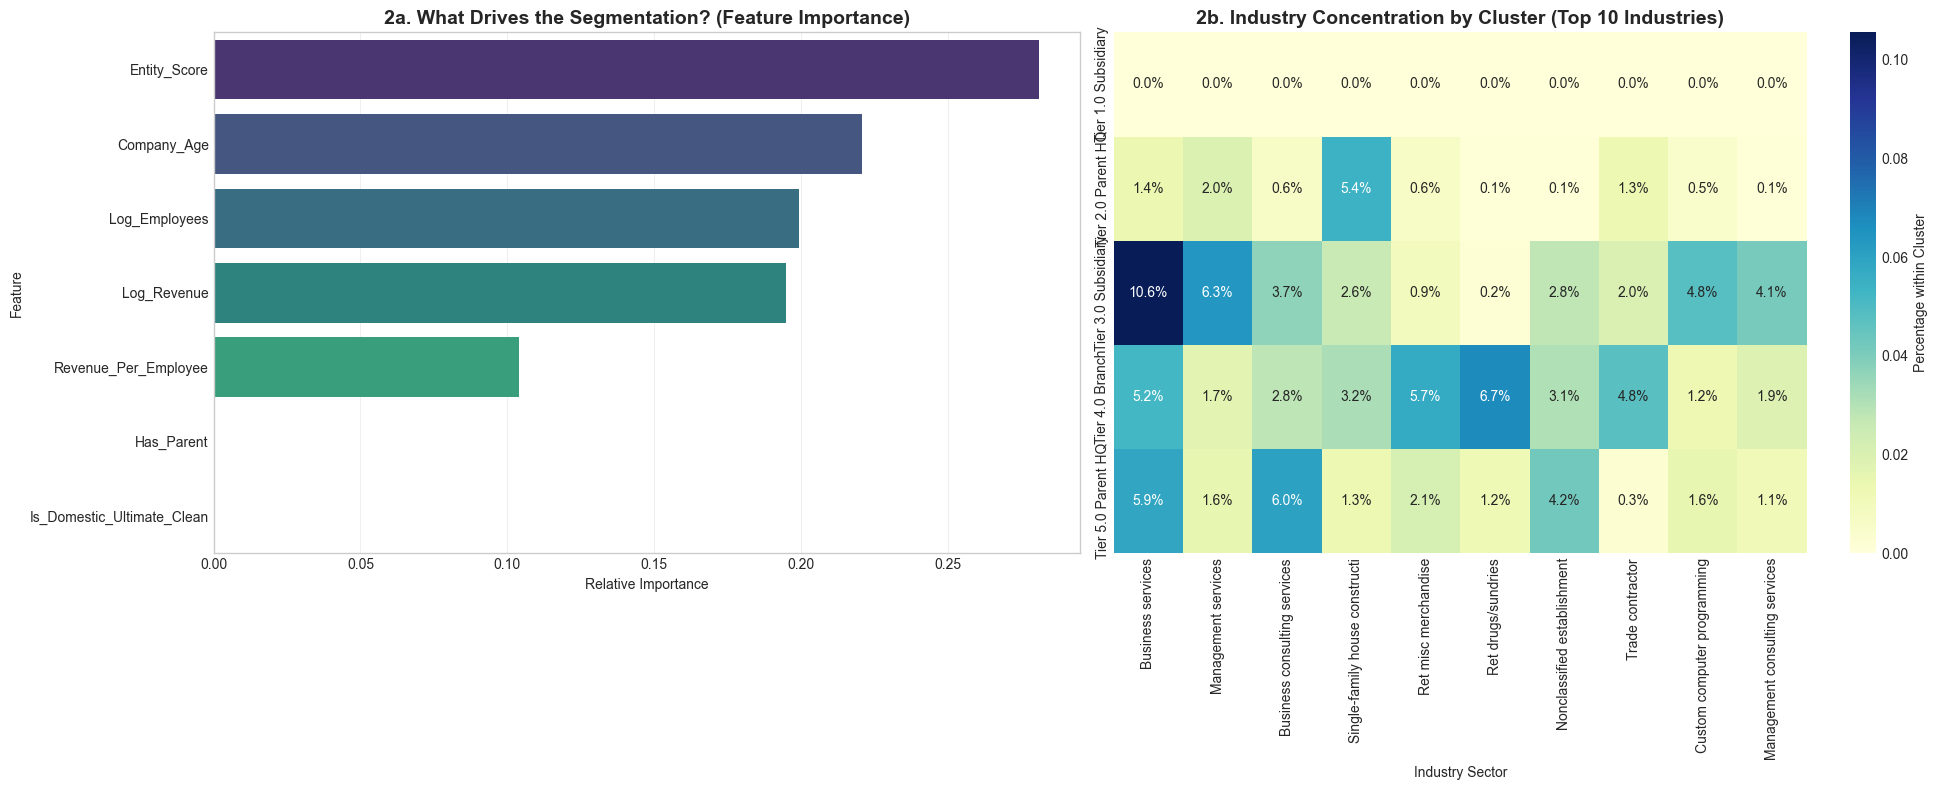

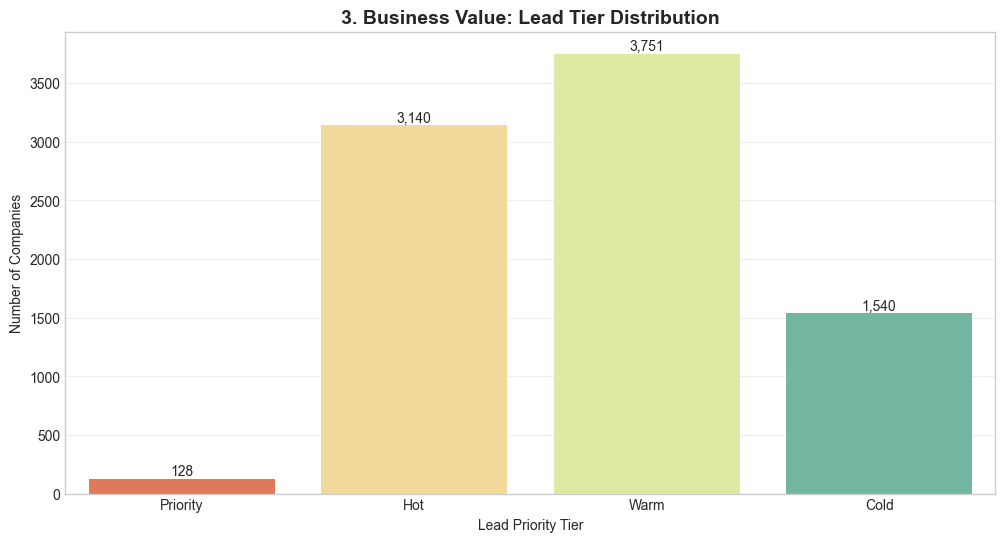

✅ Visualization Complete.
   Analyzing Cluster Performance vs Industry Benchmarks...


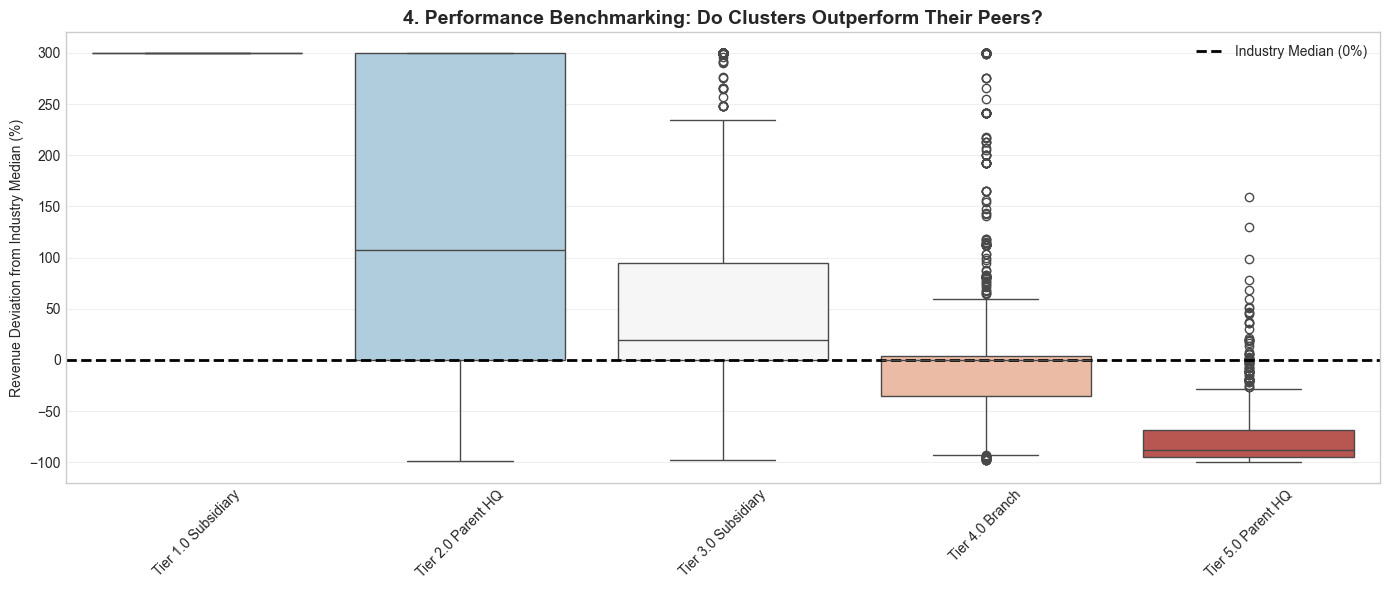


📊 Cluster Performance Summary (Median Deviation from Industry):
                     Revenue_vs_Industry  Employees_vs_Industry
Cluster_Name                                                   
Tier 1.0 Subsidiary              500.000                -89.899
Tier 2.0 Parent HQ               107.808                 54.545
Tier 3.0 Subsidiary               20.000                 63.636
Tier 4.0 Branch                    0.000                 -7.538
Tier 5.0 Parent HQ               -87.737                -53.333
   Generating Cluster Profile Radar Chart...


✅ Radar Chart Generated.


In [452]:
print("🎨 Generating Comprehensive Visualizations...")

# -------------------------------------------------------
# A. Macro View: 3D Cluster Distribution
# -------------------------------------------------------
print("   Generating 3D Macro View...")

# 我们用 'Company_Age' 或者 'Entity_Score' 作为第三维，把重叠的点拉开
fig = px.scatter_3d(
    df, 
    x='Log_Revenue', 
    y='Log_Employees', 
    z='Company_Age', # 或者换成 'Entity_Score'
    color='Cluster_Name', 
    hover_data=['Revenue (USD)', 'Employees Total', 'Entity Type'],
    title='1. Multi-Dimensional Separation (Rev vs Emp vs Age)',
    opacity=0.6,
    size_max=10
)
fig.update_layout(
    height=700,
    scene = dict(
        xaxis_title='Revenue (Log)',
        yaxis_title='Employees (Log)',
        zaxis_title='Company Age (Years)'
    )
)
fig.show()

# -------------------------------------------------------
# B. Deep Dive: Drivers & Composition (Feature Imp & Heatmap)
# -------------------------------------------------------
# Objective: To explain the causes of clustering and the industry composition of each category.
print("   Calculating Feature Importance & Industry Composition...")

from sklearn.ensemble import RandomForestClassifier

# 1. Calculating Feature Importance
# Using Random Forest to infer which features determine the clustering results
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, df['Cluster'])

importances = pd.DataFrame({
    'Feature': cluster_features, 
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# 2. Calculate Industry Heatmap
# Calculate the percentage of each industry within each cluster.
cluster_ind_ct = pd.crosstab(df['Cluster_Name'], df['SIC Description'].str[:30])
top_10_ind = cluster_ind_ct.sum().nlargest(10).index
# Standardize to percentage (to make clusters of different sizes comparable)
cluster_ind_pct = cluster_ind_ct.div(cluster_ind_ct.sum(axis=1), axis=0)

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left figure: Feature importance
sns.barplot(data=importances, x='Importance', y='Feature', ax=ax1, palette='viridis')
ax1.set_title('2a. What Drives the Segmentation? (Feature Importance)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Relative Importance')
ax1.grid(axis='x', alpha=0.3)

# Right figure: Industry heat map
sns.heatmap(cluster_ind_pct[top_10_ind], annot=True, fmt='.1%', cmap='YlGnBu', ax=ax2, cbar_kws={'label': 'Percentage within Cluster'})
ax2.set_title('2b. Industry Concentration by Cluster (Top 10 Industries)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')
ax2.set_xlabel('Industry Sector')

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# C. Business Outcome: Lead Tier Distribution
# -------------------------------------------------------
# Objective: To demonstrate the final business value conversion (how many of these are high-priority customers).
plt.figure(figsize=(12, 6))
ax = sns.countplot(df, x='Lead_Tier', palette='Spectral', order=['Priority', 'Hot', 'Warm', 'Cold'])

# Add specific numerical labels to the pillars
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')

plt.title('3. Business Value: Lead Tier Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Lead Priority Tier')
plt.ylabel('Number of Companies')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("✅ Visualization Complete.")

# -------------------------------------------------------
# D. Cluster Performance Benchmarking (vs Industry Peers)
# -------------------------------------------------------
# Objective: Visualize if clusters are "Over-performers" or "Under-performers" relative to their specific industries.
print("   Analyzing Cluster Performance vs Industry Benchmarks...")

plt.figure(figsize=(14, 6))

# We will use the 'Revenue_vs_Industry' calculated in Section 7.
# To make the visualization clearer, we'll limit the range of outliers (e.g., -100% to +300%).
plot_data = df.copy()
plot_data['Revenue_vs_Industry_Clipped'] = plot_data['Revenue_vs_Industry'].clip(upper=300, lower=-100)

# Sort the cluster by median for better chart aesthetics.
order = plot_data.groupby('Cluster_Name')['Revenue_vs_Industry_Clipped'].median().sort_values(ascending=False).index

sns.boxplot(
    data=plot_data,
    x='Cluster_Name',
    y='Revenue_vs_Industry_Clipped',
    order=order,
    palette='RdBu_r' # Red and blue color scheme: Blue represents above-average industry performance, red represents below-average industry performance.
)

# Add a 0% baseline (Industry Median)
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Industry Median (0%)')

plt.title('4. Performance Benchmarking: Do Clusters Outperform Their Peers?', fontsize=14, fontweight='bold')
plt.ylabel('Revenue Deviation from Industry Median (%)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print the specific digital summary
print("\n📊 Cluster Performance Summary (Median Deviation from Industry):")
summary = df.groupby('Cluster_Name')[['Revenue_vs_Industry', 'Employees_vs_Industry']].median().sort_values('Revenue_vs_Industry', ascending=False)
print(summary)

# -------------------------------------------------------
# E. Cluster DNA Comparison (Radar Chart)
# -------------------------------------------------------
# Objective: Compare the "DNA" (Characteristics) of each cluster side-by-side using normalized metrics.
print("   Generating Cluster Profile Radar Chart...")

import plotly.graph_objects as go

radar_cols = ['Revenue_USD_Clean', 'Employees_Total_Clean', 'Company_Age', 'Revenue_Per_Employee', 'Entity_Score']

# Min-Max Scaling
cluster_profile = df.groupby('Cluster_Name')[radar_cols].median()
normalized_profile = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

categories = radar_cols
fig = go.Figure()

for cluster in sorted(df['Cluster_Name'].unique()):
    if cluster in normalized_profile.index:
        fig.add_trace(go.Scatterpolar(
            r=normalized_profile.loc[cluster].values,
            theta=categories,
            fill='toself',
            name=cluster,
            opacity=0.4 
        ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    title="5. Cluster DNA: Why they are different (Normalized Profile)",
    height=600
)

fig.show()
print("✅ Radar Chart Generated.")

## 12. Export Results

In [453]:
## 12. Export Results (The "Full Stack" Version)
# -------------------------------------------------------
print("💾 Exporting Full Comprehensive Results...")

output_cols = [
    # --- 1. Core Identity (For Sales Outreach) ---
    'DUNS Number ', 'Company Sites', 'Website', 
    'Address Line 1', 'City', 'State', 'Region', 'Country', 'Phone Number',
    
    # --- 2. Firmographics (Raw & Clean) ---
    'SIC Code', 'SIC Description', 'NAICS Description',
    'Year Found', 'Company_Age',               
    'Entity Type', 'Entity_Score',           
    
    # --- 3. Hierarchy Details ---
    'Parent Company',                        
    'Global Ultimate Company',                 
    'Is Domestic Ultimate',                   
    'Is_Domestic_Ultimate_Clean',            
    
    # --- 4. Financials & Scale ---
    'Revenue (USD)', 'Revenue_USD_Clean',      
    'Employees Total', 'Employees_Total_Clean',
    'Market_Value_Clean',                      
    
    # --- 5. Tech & Efficiency Metrics ---
    'IT Spend', 'IT_Spend_Clean',              
    'IT_Spend_Per_Emp',                      
    'Revenue_Per_Employee',                  
    'Revenue_vs_Industry',                    
    
    # --- 6. AI Model Output (The Gold) ---
    'Cluster', 'Cluster_Name',                
    'Lead_Score', 'Lead_Tier',                
    
    # --- 7. Risk Intelligence ---
    'Risk_Flags', 'Risk_Shell',               
    'Risk_DataQuality', 'Risk_OrphanSub',
    'Anomaly_Label', 'Risk_Flag_Anomaly'         
]

# Safety Checks
valid_cols = [c for c in output_cols if c in df.columns]

# Export
df[valid_cols].to_csv('company_segmentation_results_full.csv', index=False)

print(f"✅ Successfully exported {len(valid_cols)} columns to 'company_segmentation_results_full.csv'")
print("   Includes: Contact Info, Hierarchy, Financials, AI Scores & Risks.")

# Preview
print("\n📋 Final Data Preview:")
print(df[['Company Sites', 'Cluster_Name', 'Region', 'Risk_Shell']].head(5))

💾 Exporting Full Comprehensive Results...
✅ Successfully exported 39 columns to 'company_segmentation_results_full.csv'
   Includes: Contact Info, Hierarchy, Financials, AI Scores & Risks.

📋 Final Data Preview:
                                       Company Sites         Cluster_Name  \
0  Zyf Lopsking Material Technology Co., Ltd. No....      Tier 4.0 Branch   
1  Beijing Kaishi Lide Commerce And Trade Co., Lt...   Tier 5.0 Parent HQ   
2  Keshan Shengren Potato Industry Processing Co....  Tier 3.0 Subsidiary   
3  Zuoquan County Yuanfeng Agriculture Technology...   Tier 5.0 Parent HQ   
4  Zuoquan County Tianxin Real Estate Development...   Tier 5.0 Parent HQ   

  Region  Risk_Shell  
0   Asia       False  
1   Asia       False  
2   Asia       False  
3   Asia       False  
4   Asia       False  


## 13. AI-Powered Insights
We integrate Large Language Models (Gemini API) to generate interpretable business intelligence:
1.  **Cluster Personas**: Automatically naming and describing market segments.
2.  **Anomaly Explanation**: Rationalizing why specific data points are flagged as outliers.
3.  **Battle Reports**: Generating actionable sales strategies for specific leads.

In [454]:
%env GEMINI_API_KEY=[FILL IN YOUR API KEY HERE]

env: GEMINI_API_KEY=[FILL IN YOUR API KEY HERE]


In [455]:
"""
LLM Insights Module for Company Intelligence Analysis
SDS Datathon 2026

This module provides AI-powered insight generation using Google Gemini API.
It offers three main capabilities:
- Cluster persona generation
- Anomaly explanation
- Company comparison analysis

Usage:
    from llm_insights import CompanyInsightGenerator
    llm = CompanyInsightGenerator(api_key='your-key')
    insight = llm.generate_cluster_insight(cluster_id, profile)

Requires: GEMINI_API_KEY environment variable or pass api_key directly.
"""

import os
import google.generativeai as genai
from typing import Dict, List, Any
import pandas as pd
import json


class CompanyInsightGenerator:
    """
    Generates intelligent insights for company analysis using Large Language Models.
    Defaults to Google Gemini API.
    """

    def __init__(self, api_key: str = None, model_name: str = 'gemini-3-flash-preview'):
        self.api_key = api_key or os.getenv("GEMINI_API_KEY")
        self.enabled = False

        if not self.api_key:
            print("⚠️ Warning: GEMINI_API_KEY not found. Intelligent features will run in mock mode.")
            print("To enable: import os; os.environ['GEMINI_API_KEY'] = 'your_key'")
        else:
            try:
                genai.configure(api_key=self.api_key)
                self.model = genai.GenerativeModel(model_name)
                self.enabled = True
                print(f"✅ LLM Insight Generator initialized with {model_name}")
            except Exception as e:
                print(f"❌ Failed to initialize LLM: {e}")

    def generate_cluster_insight(self, cluster_id: int, profile: Dict[str, Any], key_features: List[str] = None) -> str:
        """Generates a business persona and strategic analysis for a company cluster."""
        if not self.enabled:
            return f"Cluster {cluster_id} Analysis (Mock): This cluster contains {profile.get('Size', 'N/A')} companies. Enable LLM for detailed persona."

        prompt = f"""
        Act as a Senior Business Strategy Consultant. Analyze the following data profile for a group of companies (Cluster {cluster_id}).

        DATA PROFILE:
        - Size: {profile.get('Size', 'N/A')} companies ({profile.get('Percentage', 'N/A')} of total)
        - Median Revenue: ${profile.get('Median_Revenue_USD', 0):,.2f}
        - Median Employees: {profile.get('Median_Employees', 0):,.0f}
        - Top Region: {profile.get('Top_Region', 'N/A')}
        - Top Industry: {profile.get('Top_Industry', 'N/A')}
        - Primary Entity Type: {profile.get('Top_Entity_Type', 'N/A')}

        TASK:
        1. create a short, professional "Persona Name" for this cluster (e.g., "Asian Tech SMBs", "Global Enterprise HQs").
        2. Write a 2-sentence "Executive Summary" defining their key operational characteristics.
        3. Identify 3 "Strategic Needs" these companies likely have (e.g., cloud migration, credit lines, export compliance).

        OUTPUT FORMAT:
        **Persona:** [Name]
        **Summary:** [Text]
        **Strategic Needs:**
        - [Need 1]
        - [Need 2]
        - [Need 3]
        """

        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            return f"Error generating insight: {e}"

    def explain_anomaly(self, company_row: pd.Series, cluster_avg: pd.Series) -> str:
        """Explains why a specific company is flagged as an anomaly compared to its cluster peers."""
        if not self.enabled:
            return "Anomaly Explanation (Mock): This company's metrics deviate significantly from the cluster average."

        prompt = f"""
        Act as a Risk Assessment Analyst. A company has been flagged as an 'Anomaly' by our Isolation Forest algorithm.
        Explain WHY based on the comparison below.

        COMPANY DATA:
        - Name/ID: {company_row.get('DUNS Number ', 'Unknown')}
        - Revenue: ${company_row.get('Revenue_USD_Clean', 0):,.2f}
        - Employees: {company_row.get('Employees_Total_Clean', 0):,.0f}
        - Region: {company_row.get('Region', 'N/A')}

        CLUSTER AVERAGE ({company_row.get('Cluster_Name', 'Unknown')}):
        - Avg Revenue: ${cluster_avg.get('Revenue_USD_Clean', 0):,.2f}
        - Avg Employees: {cluster_avg.get('Employees_Total_Clean', 0):,.0f}

        TASK:
        1. Identify the specific metric(s) that look unusual (too high? too low? mismatch?).
        2. Assess if this looks like a "High Performance" outlier (good) or a "Data Error/Financial Risk" outlier (bad).
        3. Provide a one-sentence recommendation for the analyst.

        Keep it concise (approx 100 words).
        """

        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            return f"Error explaining anomaly: {e}"

    def compare_companies(self, company_a: pd.Series, company_b: pd.Series) -> str:
        """Compares two companies and suggests competitive insights."""
        if not self.enabled:
            return "Company Comparison (Mock): Enable LLM to see detailed competitive analysis."

        prompt = f"""
        Compare these two companies for a sales strategy report.

        Company A:
        - Employees: {company_a.get('Employees_Total_Clean', 0)}
        - Revenue: ${company_a.get('Revenue_USD_Clean', 0):,.2f}
        - Region: {company_a.get('Region', 'N/A')}
        - Industry: {company_a.get('SIC Description', 'N/A')}

        Company B:
        - Employees: {company_b.get('Employees_Total_Clean', 0)}
        - Revenue: ${company_b.get('Revenue_USD_Clean', 0):,.2f}
        - Region: {company_b.get('Region', 'N/A')}
        - Industry: {company_b.get('SIC Description', 'N/A')}

        TASK:
        1. Highlight the biggest difference between them.
        2. Suggest which one is the "Leader" and which is the "Challenger" (or if they are peers).
        """

        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            return f"Error comparing companies: {e}"

    def generate_action_report(self, company_row: pd.Series) -> Dict[str, str]:
        """
        Generates a 'Battle Report' (Verdict, Reason, Risk, Action) for a company.
        Returns a dictionary.
        """
        if not self.enabled:
            return {
                "Method": "LLM-Based (Mock)",
                "Verdict": "🤖 AI VERDICT (Simulated)",
                "Reason": "Enable LLM to generate natural language analysis.",
                "Risk": "AI would identify risks here.",
                "Action": "Enable LLM for specific recommendations."
            }

        prompt = f'''
        Act as a Senior Sales & Risk Analyst. Analyze this company for our B2B Sales Team.

        COMPANY DATA:
        - Name: {company_row.get('DUNS Number ', 'Unknown')}
        - Cluster: {company_row.get('Cluster_Name', 'Unknown')}
        - Revenue: ${company_row.get('Revenue_USD_Clean', 0):,.0f}
        - Employees: {company_row.get('Employees_Total_Clean', 0):,.0f}
        - Lead Score: {company_row.get('Lead_Score', 0)} ({company_row.get('Lead_Tier', 'Unknown')})
        - Risk Flags: {company_row.get('Risk_Flags', 0)}
        - Details: Anomaly={company_row.get('Anomaly_Label', 'N/A')}, Shell={company_row.get('Risk_Shell', False)}

        OUTPUT JSON FORMAT:
        {{
            "Verdict": "Short powerful phrase (e.g., 'Prime Acquisition Target' or 'Stay Away')",
            "Reason": "One sharp sentence explaining why, highlighting nuances.",
            "Risk": "Assessment of risk, detecting subtleties (e.g., 'Revenue seems too high for team size').",
            "Action": "Specific recommendation (e.g., 'Send VP of Sales', 'Request Financial Audit')."
        }}

        Return ONLY VALID JSON.
        '''

        try:
            response = self.model.generate_content(prompt)
            text = response.text.strip()
            # Clean potential markdown
            if text.startswith("```json"):
                text = text[7:]
            if text.endswith("```"):
                text = text[:-3]
            return json.loads(text.strip())
        except Exception as e:
            return {"Method": "LLM-Based", "Error": str(e)}


In [456]:
# Initialize AI Generator
# Ensure GEMINI_API_KEY is set in environment variables
try:
    llm = CompanyInsightGenerator()
    print("✅ AI Engine Initialized")
except Exception as e:
    print(f"⚠️ AI Initialization Failed: {e}")

✅ LLM Insight Generator initialized with gemini-3-flash-preview
✅ AI Engine Initialized


### 13.1 Generate Action Report (Example)
Simulating a 'Action Report' for a high-priority lead.

In [457]:
if llm.enabled:
    # Pick a high-value sample
    sample_company = df[df['Lead_Tier'] == 'Priority'].iloc[3]

    print(f"⚔️ Generatng Action Report for: {sample_company['DUNS Number ']}...")
    report = llm.generate_action_report(sample_company)

    print(report)
    print("\n" + "="*40)
    print(f"🎯 VERDICT: {report.get('Verdict')}")
    print("="*40)
    print(f"⚡ ACTION:  {report.get('Action')}")
    print(f"📝 REASON:  {report.get('Reason')}")
    print(f"⚠️ RISK:    {report.get('Risk')}")
else:
    print("Skipping AI demo (No API Key detected)")

⚔️ Generatng Action Report for: 638006884...
{'Method': 'LLM-Based', 'Error': '400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"\ndomain: "googleapis.com"\nmetadata {\n  key: "service"\n  value: "generativelanguage.googleapis.com"\n}\n, locale: "en-US"\nmessage: "API key not valid. Please pass a valid API key."\n]'}

🎯 VERDICT: None
⚡ ACTION:  None
📝 REASON:  None
⚠️ RISK:    None
